# Evaluation Code for KSQL and ML
Before evaluating, please run KSQL infrastructure with `test.pcap` generated from `../datasets/preparation2.py`, then run `../rule-detection/evaluation/consumer/script.py` to consume the results from Kafka, and lastly run `../rule-detection/evaluation/ksql_evaluation_dos.py` and `../rule-detection/evaluation/ksql_evaluation_ps.py` to find list of packets in the pcap (in the form of index) that is malicious/detected.

**Metrics**
- Accuracy, Precision, Recall, F1-Score
- Inference Time for ML

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import joblib
import time

In [3]:
DOS_MODEL_LOCATION = "../ai-detection/notebooks/modelsdoscrossval/postfs"
PS_MODEL_LOCATION = "../ai-detection/notebooks/models/postfs"

## Post-Processing for KSQL Predictions

In [3]:
# Get PCAP Indexes of all flows
# For example, if 125th, 126th, and 127th is part of k-th flow (in whole dataset train & test), then flow_packets[k] = [125, 126, 127]
flow_packets = []
with open("../datasets/output-old/pcap_indexes_run_index.txt") as file:
    for line in file:
        indexes = line.strip().split(",")
        if len(indexes[-1]) == 0:
            indexes = indexes[:-1]
        indexes = [int(x) for x in indexes]
        flow_packets.append(indexes)

In [4]:
# Creating mapping to convert whole dataset PCAP indexes to test dataset PCAP indexes
full_to_test_mapping = {}
with open("../datasets/output-old/test_pcap_index_mapping.txt") as file:
    for line in file:
        before, after = line.strip().split(",")
        before = int(before)
        after = int(after)
        assert before not in full_to_test_mapping
        full_to_test_mapping[before] = after

In [5]:
# Convert using mapping
test_flow_packets = []
for cur_packets in flow_packets:
    new_packets = []
    is_in_test = True

    debug_partial = False
    for idx in cur_packets:
        if idx not in full_to_test_mapping:
            is_in_test = False
            assert not debug_partial # if assertion error, there may be problem in your dataset preparation
            break
        debug_partial = True
        new_packets.append(full_to_test_mapping[idx])
    if is_in_test:
        test_flow_packets.append(new_packets)
    else:
        test_flow_packets.append(None)

In [6]:
test_flow_packets_set = [set(i) if i is not None else None for i in test_flow_packets]

In [7]:
np_test_flow_packets_set = pd.Series(np.array(test_flow_packets_set))
flow_packets_set_test_only = np_test_flow_packets_set[~np_test_flow_packets_set.isna()]

In [8]:
with open("../rule-detection/evaluation/detected_ksql_2_slowloris.txt") as file:
    detected_dos_idxs = [int(x.strip()) for x in file.readlines()]
detected_dos_idx_set = set(detected_dos_idxs)

with open("../rule-detection/evaluation/detected_ksql_2_portscan.txt") as file:
    detected_portscan_idxs = [int(x.strip()) for x in file.readlines()]
detected_portscan_idx_set = set(detected_portscan_idxs)

In [9]:
is_detected_dos = np.array([len(detected_dos_idx_set.intersection(flow_packet_set)) > 0 for flow_packet_set in flow_packets_set_test_only.values])
is_detected_dos = pd.Series(is_detected_dos)

is_detected_portscan = np.array([len(detected_portscan_idx_set.intersection(flow_packet_set)) > 0 for flow_packet_set in flow_packets_set_test_only.values])
is_detected_portscan = pd.Series(is_detected_portscan)

In [10]:
is_detected_dos.index = flow_packets_set_test_only.index
is_detected_portscan.index = flow_packets_set_test_only.index

In [11]:
# Load Test Dataset
flink_test = pd.read_csv('../datasets/output/test_final.csv', parse_dates=['Timestamp'], index_col=0)

In [12]:
assert set(flink_test['Old Index'].values).issubset(set(is_detected_dos.index))
assert set(flink_test['Old Index'].values).issubset(set(is_detected_portscan.index))

In [13]:
is_detected_dos_df = pd.DataFrame(is_detected_dos, columns=['Binary Prediction']).reset_index().rename(columns={'index': 'Old Index'})
is_detected_dos_df['Binary Prediction'] = np.where(is_detected_dos_df['Binary Prediction'], 'Slowloris', 'Not Slowloris')

is_detected_ps_df = pd.DataFrame(is_detected_portscan, columns=['Binary Prediction']).reset_index().rename(columns={'index': 'Old Index'})
is_detected_ps_df['Binary Prediction'] = np.where(is_detected_ps_df['Binary Prediction'], 'Portscan', 'Not Portscan')

In [14]:
flink_test_binary_dos = flink_test.merge(is_detected_dos_df, on=['Old Index'], how='left', indicator=True)
flink_test_binary_ps = flink_test.merge(is_detected_ps_df, on=['Old Index'], how='left', indicator=True)

In [15]:
flink_test_binary_dos["_merge"].value_counts()

_merge
both          153696
left_only          0
right_only         0
Name: count, dtype: int64

In [16]:
flink_test_binary_ps["_merge"].value_counts()

_merge
both          153696
left_only          0
right_only         0
Name: count, dtype: int64

In [17]:
flink_test_binary_dos['Binary Label'] = np.where(flink_test_binary_dos['Label'] == 'Slowloris', 'Slowloris', 'Not Slowloris')
flink_test_binary_ps['Binary Label'] = np.where(flink_test_binary_ps['Label'] == 'Portscan', 'Portscan', 'Not Portscan')

In [18]:
y_true_dos = flink_test_binary_dos['Binary Label']
y_pred_ksql_dos = flink_test_binary_dos['Binary Prediction']

y_true_ps = flink_test_binary_ps['Binary Label']
y_pred_ksql_ps = flink_test_binary_ps['Binary Prediction']

## Accuracy, Precision, Recall, F1-Score

### DoS

In [19]:
dt = joblib.load(f"{DOS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{DOS_MODEL_LOCATION}/rf_tuned.pkl")
et = joblib.load(f"{DOS_MODEL_LOCATION}/et_tuned.pkl")
xg = joblib.load(f"{DOS_MODEL_LOCATION}/xg_tuned.pkl")
lgbm = joblib.load(f"{DOS_MODEL_LOCATION}/lgbm_tuned.pkl")
cat = joblib.load(f"{DOS_MODEL_LOCATION}/cat_tuned.pkl")
stk1 = joblib.load(f"{DOS_MODEL_LOCATION}/stk1_tuned.pkl")
stk2 = joblib.load(f"{DOS_MODEL_LOCATION}/stk2_tuned.pkl")
stk3 = joblib.load(f"{DOS_MODEL_LOCATION}/stk3_tuned.pkl")

fs = ['Fwd Seg Size Min', 'Bwd Packet Length Mean', 'FWD Init Win Bytes', 'Fwd IAT Max', 'Bwd RST Flags', 'Bwd Packet Length Max', 'FIN Flag Count', 'Fwd IAT Min', 'Protocol', 'Bwd Segment Size Avg', 'Flow IAT Mean', 'Fwd Packet Length Max', 'Down/Up Ratio', 'Flow IAT Min', 'RST Flag Count', 'Flow Duration', 'Subflow Fwd Packets', 'Flow IAT Max', 'Flow Packets/s', 'Active Min', 'Bwd IAT Min', 'Bwd Act Data Pkts', 'Bwd Init Win Bytes', 'Bwd IAT Max', 'SYN Flag Count', 'Idle Max', 'Fwd IAT Total', 'Total Length of Bwd Packet', 'Fwd IAT Mean', 'Fwd Packets/s', 'Average Packet Size', 'Bwd IAT Mean', 'Total Bwd packets', 'Bwd Packets/s', 'Bwd IAT Total', 'Packet Length Mean', 'Packet Length Max', 'Bwd PSH Flags', 'Flow IAT Std', 'Packet Length Std', 'Fwd Bulk Rate Avg', 'Fwd Segment Size Avg', 'Fwd Packet Length Min', 'Fwd IAT Std', 'Fwd Packet Length Std', 'Flow Bytes/s', 'Fwd Bytes/Bulk Avg', 'ACK Flag Count', 'Packet Length Variance']

top_3_models = ['xg', 'et', 'lgbm']

labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Slowloris', 'Slowloris'])

X_test_fs = flink_test[fs]
y_test = labelencoder.transform(flink_test_binary_dos['Binary Label'])

#### KSQL

Accuracy of KSQL: 0.7858369768894441
Precision of KSQL: 0.4953329286897751
Recall of KSQL: 0.3958494474232751
F1-score of KSQL: 0.4400384733091418
               precision    recall  f1-score   support

Not Slowloris    0.99067   0.79170   0.88008    152558
    Slowloris    0.00000   0.00000   0.00000      1138

     accuracy                        0.78584    153696
    macro avg    0.49533   0.39585   0.44004    153696
 weighted avg    0.98333   0.78584   0.87356    153696



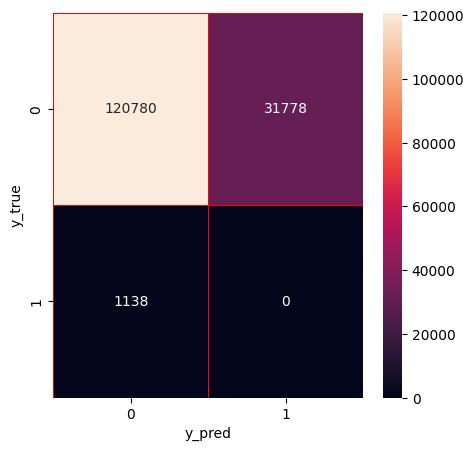

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_fscore_support, accuracy_score

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_pred_ksql_dos, average='macro')

# Print results
print('Accuracy of KSQL: ' + str(accuracy_score(y_true_dos, y_pred_ksql_dos)))
print('Precision of KSQL: ' + str(precision))
print('Recall of KSQL: ' + str(recall))
print('F1-score of KSQL: ' + str(fscore))
print(classification_report(y_true_dos, y_pred_ksql_dos, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_pred_ksql_dos)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Machine Learning

Prediction time per sample:  0.00011530328040169648
Accuracy of DT: 0.9998828856964397
Precision of DT: 0.9943117096617538
Recall of DT: 0.9977605566983531
F1-score of DT: 0.9960300469068781
               precision    recall  f1-score   support

Not Slowloris    0.99997   0.99991   0.99994    152558
    Slowloris    0.98866   0.99561   0.99212      1138

     accuracy                        0.99988    153696
    macro avg    0.99431   0.99776   0.99603    153696
 weighted avg    0.99988   0.99988   0.99988    153696



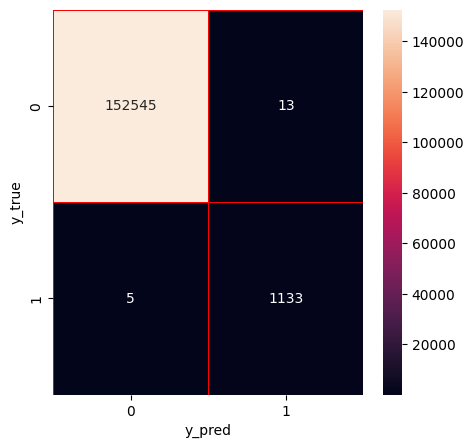

In [21]:
# Decision Tree
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test_fs)
end = time.time()

predict_time_dt = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_dt)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of DT: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [22]:
from sklearn.tree import export_graphviz
import graphviz

# Export to DOT format
dot_data = export_graphviz(
    dt,
    out_file=None,
    feature_names=X_test_fs.columns.tolist(),  # Feature names
    class_names=['Not Slowloris', 'Slowloris'],                        # Class names (if classification)
    filled=True,                             # Color nodes
    rounded=True,                            # Rounded boxes
    special_characters=True,                 # Special symbols
)

# Render and display
graph = graphviz.Source(dot_data)
graph.render("decision_tree", format="png", cleanup=True)  # Saves as 'decision_tree.png'
graph.view()  # Opens in default viewer

'decision_tree.pdf'

Prediction time per sample:  0.0021088307608223794


kf.service.services: KApplicationTrader: mimeType "x-scheme-handler/file" not found
Icon theme "Nordic-bluish" not found.
kf.service.services: KApplicationTrader: mimeType "x-scheme-handler/file" not found


Opening in existing browser session.
Accuracy of RF: 0.9976642202789923
Precision of RF: 0.9981892101689394
Recall of RF: 0.8427032251941818
F1-score of RF: 0.9058740854935726
               precision    recall  f1-score   support

Not Slowloris    0.99766   0.99999   0.99882    152558
    Slowloris    0.99872   0.68541   0.81292      1138

     accuracy                        0.99766    153696
    macro avg    0.99819   0.84270   0.90587    153696
 weighted avg    0.99767   0.99766   0.99745    153696



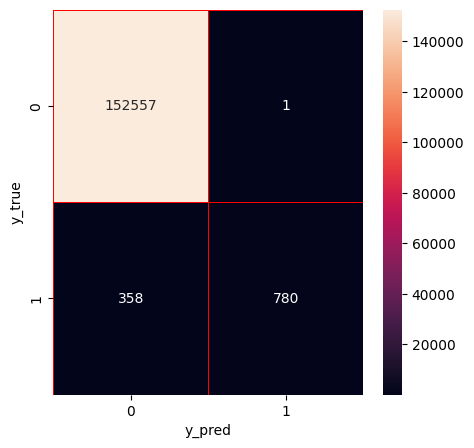

In [23]:
# Random Forest
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test_fs)
end = time.time()

predict_time_rf = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_rf)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of RF: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0017901357824098014
Accuracy of ET: 0.9976902456797835
Precision of ET: 0.9982055212417598
Recall of ET: 0.84446069443847
F1-score of ET: 0.9071152341590751
               precision    recall  f1-score   support

Not Slowloris    0.99768   0.99999   0.99884    152558
    Slowloris    0.99873   0.68893   0.81539      1138

     accuracy                        0.99769    153696
    macro avg    0.99821   0.84446   0.90712    153696
 weighted avg    0.99769   0.99769   0.99748    153696



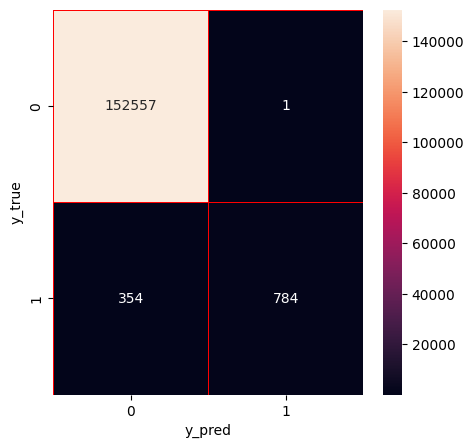

In [24]:
# Extra Trees
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_test_fs)
end = time.time()

predict_time_et = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_et)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of ET: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.000425123644699138
Accuracy of XG: 0.9980415885904643
Precision of XG: 0.9984227431150585
Recall of XG: 0.8681865292363611
F1-score of XG: 0.9233817852804924
               precision    recall  f1-score   support

Not Slowloris    0.99804   0.99999   0.99901    152558
    Slowloris    0.99881   0.73638   0.84775      1138

     accuracy                        0.99804    153696
    macro avg    0.99842   0.86819   0.92338    153696
 weighted avg    0.99804   0.99804   0.99789    153696



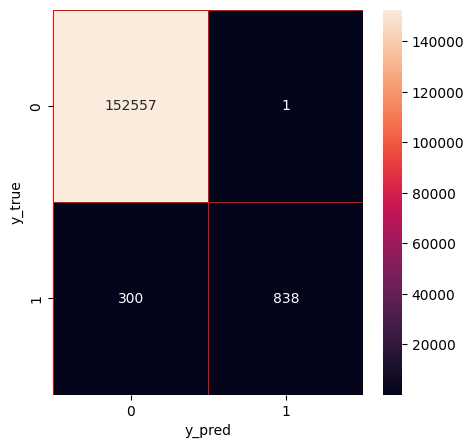

In [25]:
# XGBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test_fs)
end = time.time()

predict_time_xg = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_xg)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of XG: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of XG: ' + str(precision))
print('Recall of XG: ' + str(recall))
print('F1-score of XG: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0006541991367852367
Accuracy of LGBM: 0.9976902456797835
Precision of LGBM: 0.9963237835015759
Recall of LGBM: 0.8457689640456201
F1-score of LGBM: 0.9074023259869605
               precision    recall  f1-score   support

Not Slowloris    0.99770   0.99997   0.99884    152558
    Slowloris    0.99494   0.69156   0.81597      1138

     accuracy                        0.99769    153696
    macro avg    0.99632   0.84577   0.90740    153696
 weighted avg    0.99768   0.99769   0.99748    153696



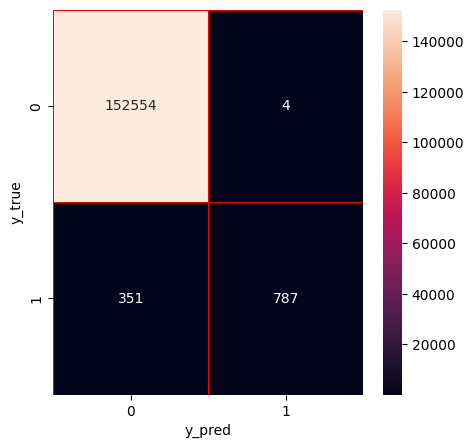

In [26]:
# LightGBM
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test_fs)
end = time.time()

predict_time_lgbm = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_lgbm)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of LGBM: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of LGBM: ' + str(precision))
print('Recall of LGBM: ' + str(recall))
print('F1-score of LGBM: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00031796124436670164
Accuracy of Cat: 0.9976967520299813
Precision of Cat: 0.9982095939286744
Recall of Cat: 0.8449000617495421
F1-score of Cat: 0.9074247192413416
               precision    recall  f1-score   support

Not Slowloris    0.99769   0.99999   0.99884    152558
    Slowloris    0.99873   0.68981   0.81601      1138

     accuracy                        0.99770    153696
    macro avg    0.99821   0.84490   0.90742    153696
 weighted avg    0.99770   0.99770   0.99749    153696



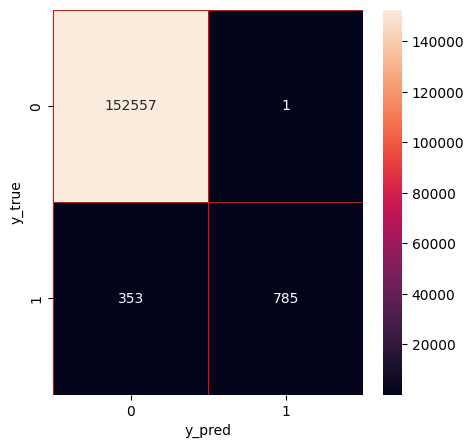

In [27]:
# CatBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of Cat: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of Cat: ' + str(precision))
print('Recall of Cat: ' + str(recall))
print('F1-score of Cat: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [28]:
top_3_models

['xg', 'et', 'lgbm']

Prediction time per sample:  0.008163259733276716
Accuracy of OCSE: 0.9976902456797835
Precision of OCSE: 0.9963237835015759
Recall of OCSE: 0.8457689640456201
F1-score of OCSE: 0.9074023259869605
               precision    recall  f1-score   support

Not Slowloris    0.99770   0.99997   0.99884    152558
    Slowloris    0.99494   0.69156   0.81597      1138

     accuracy                        0.99769    153696
    macro avg    0.99632   0.84577   0.90740    153696
 weighted avg    0.99768   0.99769   0.99748    153696



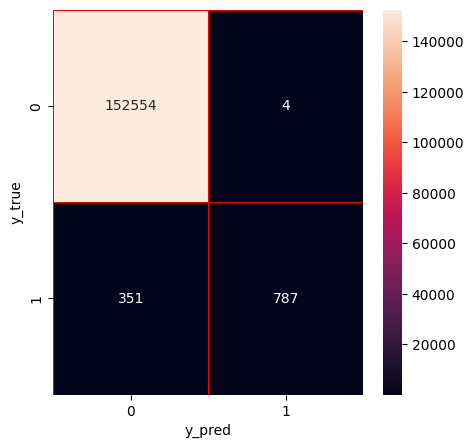

In [31]:
# OCSE

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()

model_1_test = xg.predict(X_test_fs).reshape(-1, 1)
model_2_test = et.predict(X_test_fs).reshape(-1, 1)
model_3_test = lgbm.predict(X_test_fs).reshape(-1, 1)

model_1_prob_test = xg.predict_proba(X_test_fs)
model_2_prob_test = et.predict_proba(X_test_fs)
model_3_prob_test = lgbm.predict_proba(X_test_fs)

x_test = np.concatenate([model_1_test, model_2_test, model_3_test] + [model_1_prob_test, model_2_prob_test, model_3_prob_test], axis=1)

y_predict = stk3.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of OCSE: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of OCSE: ' + str(precision))
print('Recall of OCSE: ' + str(recall))
print('F1-score of OCSE: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### Port Scan

In [44]:
dt = joblib.load(f"{PS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{PS_MODEL_LOCATION}/rf_tuned.pkl")
et = joblib.load(f"{PS_MODEL_LOCATION}/et_tuned.pkl")
xg = joblib.load(f"{PS_MODEL_LOCATION}/xg_tuned.pkl")
lgbm = joblib.load(f"{PS_MODEL_LOCATION}/lgbm_tuned.pkl")
cat = joblib.load(f"{PS_MODEL_LOCATION}/cat_tuned.pkl")
stk1 = joblib.load(f"{PS_MODEL_LOCATION}/stk1_tuned.pkl")
stk2 = joblib.load(f"{PS_MODEL_LOCATION}/stk2_tuned.pkl")
stk3 = joblib.load(f"{PS_MODEL_LOCATION}/stk3_tuned.pkl")

fs = ['Flow Duration', 'Bwd RST Flags', 'RST Flag Count', 'Packet Length Mean', 'Protocol', 'Fwd Seg Size Min', 'Average Packet Size', 'Flow IAT Max', 'Fwd Packet Length Max', 'Packet Length Max', 'Bwd Packet Length Max', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Fwd Act Data Pkts', 'Total Length of Fwd Packet', 'Bwd Packet Length Mean', 'FWD Init Win Bytes', 'Total Length of Bwd Packet', 'Bwd Act Data Pkts', 'Packet Length Std']

top_3_models = ['et', 'lgbm', 'rf']

labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Portscan', 'Portscan'])

X_test_fs = flink_test[fs]
y_test = labelencoder.transform(flink_test_binary_ps['Binary Label'])

#### KSQL

Accuracy of KSQL: 0.9881389235894232
Precision of KSQL: 0.9887785125172622
Recall of KSQL: 0.9881389235894232
F1-score of KSQL: 0.9882590722966741
              precision    recall  f1-score   support

Not Portscan    0.99998   0.98507   0.99247    121888
    Portscan    0.94587   0.99991   0.97214     31808

    accuracy                        0.98814    153696
   macro avg    0.97292   0.99249   0.98230    153696
weighted avg    0.98878   0.98814   0.98826    153696



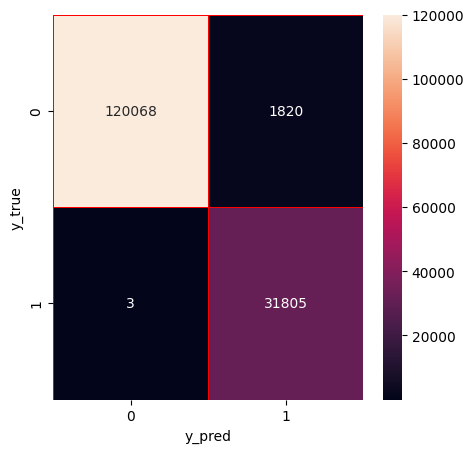

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_fscore_support, accuracy_score

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_pred_ksql_ps, average='weighted')

# Print results
print('Accuracy of KSQL: ' + str(accuracy_score(y_true_ps, y_pred_ksql_ps)))
print('Precision of KSQL: ' + str(precision))
print('Recall of KSQL: ' + str(recall))
print('F1-score of KSQL: ' + str(fscore))
print(classification_report(y_true_ps, y_pred_ksql_ps, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_pred_ksql_ps)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Machine Learning

Prediction time per sample:  5.1988082058152236e-05
Accuracy of DT: 0.9990045284197376
Precision of DT: 0.9985587577938333
Recall of DT: 0.998408147922716
F1-score of DT: 0.9984834305994229
              precision    recall  f1-score   support

Not Portscan    0.99932   0.99943   0.99937    121888
    Portscan    0.99780   0.99739   0.99759     31808

    accuracy                        0.99900    153696
   macro avg    0.99856   0.99841   0.99848    153696
weighted avg    0.99900   0.99900   0.99900    153696



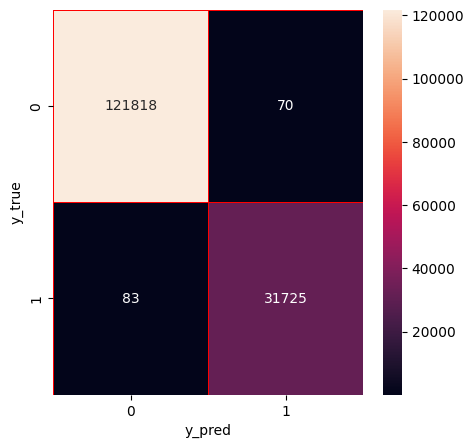

In [34]:
# Decision Tree
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test_fs)
end = time.time()

predict_time_dt = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_dt)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'Portscan', 'Not Portscan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of DT: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0011570582582432851
Accuracy of RF: 0.999590099937539
Precision of RF: 0.9997416995350592
Recall of RF: 0.9990096830985915
F1-score of RF: 0.9993751670987617
              precision    recall  f1-score   support

Not Portscan    0.99948   1.00000   0.99974    121888
    Portscan    1.00000   0.99802   0.99901     31808

    accuracy                        0.99959    153696
   macro avg    0.99974   0.99901   0.99938    153696
weighted avg    0.99959   0.99959   0.99959    153696



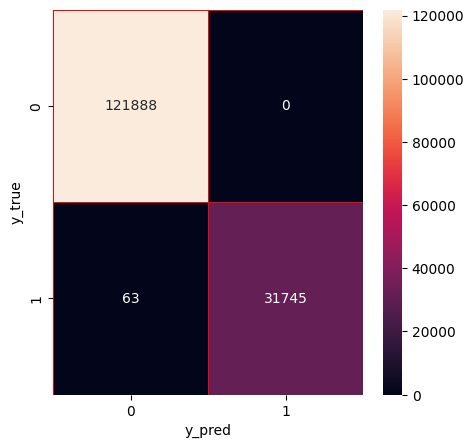

In [27]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

# Random Forest
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test_fs)
end = time.time()

predict_time_rf = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_rf)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'Portscan', 'Not Portscan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of RF: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0013822789319276859
Accuracy of ET: 0.9991021236727046
Precision of ET: 0.9994345467359416
Recall of ET: 0.9978307344064387
F1-score of ET: 0.9986301226403692
              precision    recall  f1-score   support

Not Portscan    0.99887   1.00000   0.99943    121888
    Portscan    1.00000   0.99566   0.99783     31808

    accuracy                        0.99910    153696
   macro avg    0.99943   0.99783   0.99863    153696
weighted avg    0.99910   0.99910   0.99910    153696



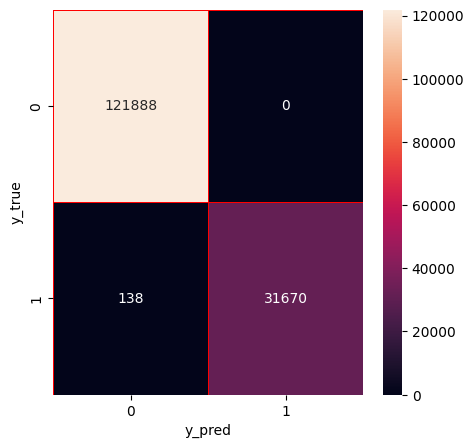

In [36]:
# Extra Trees
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_test_fs)
end = time.time()

predict_time_et = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_et)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'Portscan', 'Not Portscan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of ET: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00020534935628973195
Accuracy of XG: 0.9995575681865501
Precision of XG: 0.9997095542625132
Recall of XG: 0.9989427037084677
F1-score of XG: 0.9993255536463871
              precision    recall  f1-score   support

Not Portscan    0.99945   0.99999   0.99972    121888
    Portscan    0.99997   0.99789   0.99893     31808

    accuracy                        0.99956    153696
   macro avg    0.99971   0.99894   0.99933    153696
weighted avg    0.99956   0.99956   0.99956    153696



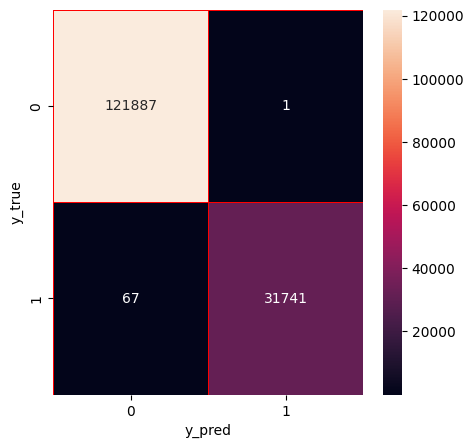

In [37]:
# XGBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test_fs)
end = time.time()

predict_time_xg = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_xg)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'Portscan', 'Not Portscan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of XG: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of XG: ' + str(precision))
print('Recall of XG: ' + str(recall))
print('F1-score of XG: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00047412870229593596
Accuracy of LGBM: 0.9995966062877368
Precision of LGBM: 0.9997457974579746
Recall of LGBM: 0.9990254024144869
F1-score of LGBM: 0.9993850922350148
              precision    recall  f1-score   support

Not Portscan    0.99949   1.00000   0.99975    121888
    Portscan    1.00000   0.99805   0.99902     31808

    accuracy                        0.99960    153696
   macro avg    0.99975   0.99903   0.99939    153696
weighted avg    0.99960   0.99960   0.99960    153696



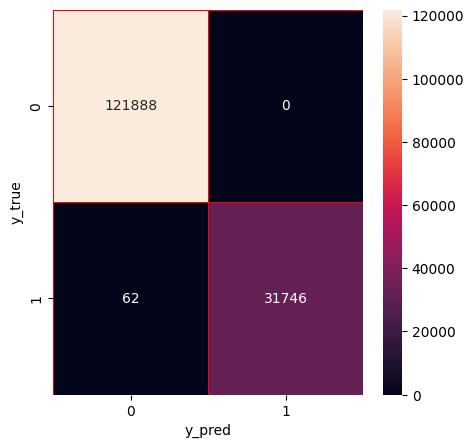

In [29]:
# LightGBM
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test_fs)
end = time.time()

predict_time_lgbm = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_lgbm)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'Portscan', 'Not Portscan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of LGBM: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of LGBM: ' + str(precision))
print('Recall of LGBM: ' + str(recall))
print('F1-score of LGBM: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00046266817982038456
Accuracy of Cat: 0.9995966062877368
Precision of Cat: 0.9997457974579746
Recall of Cat: 0.9990254024144869
F1-score of Cat: 0.9993850922350148
              precision    recall  f1-score   support

Not Portscan    0.99949   1.00000   0.99975    121888
    Portscan    1.00000   0.99805   0.99902     31808

    accuracy                        0.99960    153696
   macro avg    0.99975   0.99903   0.99939    153696
weighted avg    0.99960   0.99960   0.99960    153696



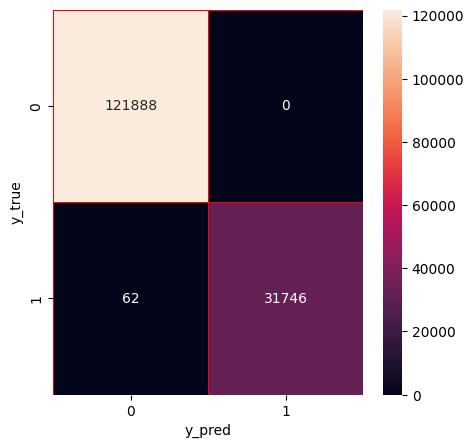

In [28]:
# CatBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'Portscan', 'Not Portscan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of Cat: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of Cat: ' + str(precision))
print('Recall of Cat: ' + str(recall))
print('F1-score of Cat: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [30]:
top_3_models

['et', 'lgbm', 'rf']

Prediction time per sample:  0.007445328115994995
Accuracy of OCSE: 0.999590099937539
Precision of OCSE: 0.9997416995350592
Recall of OCSE: 0.9990096830985915
F1-score of OCSE: 0.9993751670987617
              precision    recall  f1-score   support

Not Portscan    0.99948   1.00000   0.99974    121888
    Portscan    1.00000   0.99802   0.99901     31808

    accuracy                        0.99959    153696
   macro avg    0.99974   0.99901   0.99938    153696
weighted avg    0.99959   0.99959   0.99959    153696



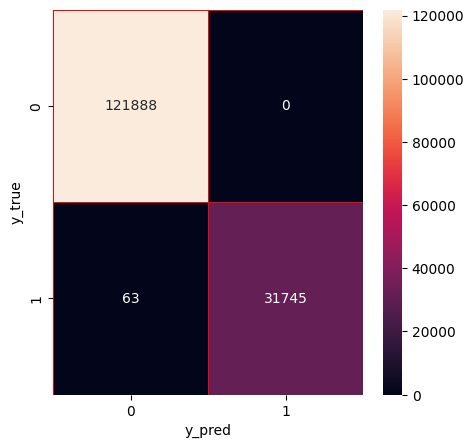

In [41]:
# OCSE

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()

model_1_test = et.predict(X_test_fs).reshape(-1, 1)
model_2_test = lgbm.predict(X_test_fs).reshape(-1, 1)
model_3_test = rf.predict(X_test_fs).reshape(-1, 1)

model_1_prob_test = et.predict_proba(X_test_fs)
model_2_prob_test = lgbm.predict_proba(X_test_fs)
model_3_prob_test = rf.predict_proba(X_test_fs)

x_test = np.concatenate([model_1_test, model_2_test, model_3_test] + [model_1_prob_test, model_2_prob_test, model_3_prob_test], axis=1)

y_predict = stk3.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'Portscan', 'Not Portscan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of OCSE: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of OCSE: ' + str(precision))
print('Recall of OCSE: ' + str(recall))
print('F1-score of OCSE: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Inference Time

In [42]:
TRIES = 100

In [43]:
# this is in milliseconds, not seconds
def calculate_inference_time_in_ms(foo, tries: int):
    times = []
    for _ in range(tries):
        start = time.time()
        foo()
        end = time.time()
        times.append(((end - start) / len(X_test_fs)) * 1000)
    return np.average(times)

In [44]:
def print_time(name: str, in_ms):
    print(f"Average Inference time for {name}")
    print(in_ms, 'milliseconds')
    print(in_ms / 1000, 'seconds')
    print()

## DoS

In [46]:
dt = joblib.load(f"{DOS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{DOS_MODEL_LOCATION}/rf_tuned.pkl")
et = joblib.load(f"{DOS_MODEL_LOCATION}/et_tuned.pkl")
xg = joblib.load(f"{DOS_MODEL_LOCATION}/xg_tuned.pkl")
lgbm = joblib.load(f"{DOS_MODEL_LOCATION}/lgbm_tuned.pkl")
cat = joblib.load(f"{DOS_MODEL_LOCATION}/cat_tuned.pkl")
stk1 = joblib.load(f"{DOS_MODEL_LOCATION}/stk1_tuned.pkl")
stk2 = joblib.load(f"{DOS_MODEL_LOCATION}/stk2_tuned.pkl")
stk3 = joblib.load(f"{DOS_MODEL_LOCATION}/stk3_tuned.pkl")

fs = ['Fwd Seg Size Min', 'Bwd Packet Length Mean', 'FWD Init Win Bytes', 'Fwd IAT Max', 'Bwd RST Flags', 'Bwd Packet Length Max', 'FIN Flag Count', 'Fwd IAT Min', 'Protocol', 'Bwd Segment Size Avg', 'Flow IAT Mean', 'Fwd Packet Length Max', 'Down/Up Ratio', 'Flow IAT Min', 'RST Flag Count', 'Flow Duration', 'Subflow Fwd Packets', 'Flow IAT Max', 'Flow Packets/s', 'Active Min', 'Bwd IAT Min', 'Bwd Act Data Pkts', 'Bwd Init Win Bytes', 'Bwd IAT Max', 'SYN Flag Count', 'Idle Max', 'Fwd IAT Total', 'Total Length of Bwd Packet', 'Fwd IAT Mean', 'Fwd Packets/s', 'Average Packet Size', 'Bwd IAT Mean', 'Total Bwd packets', 'Bwd Packets/s', 'Bwd IAT Total', 'Packet Length Mean', 'Packet Length Max', 'Bwd PSH Flags', 'Flow IAT Std', 'Packet Length Std', 'Fwd Bulk Rate Avg', 'Fwd Segment Size Avg', 'Fwd Packet Length Min', 'Fwd IAT Std', 'Fwd Packet Length Std', 'Flow Bytes/s', 'Fwd Bytes/Bulk Avg', 'ACK Flag Count', 'Packet Length Variance']

top_3_models = ['xg', 'et', 'lgbm']

labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Slowloris', 'Slowloris'])

X_test_fs = flink_test[fs]
y_test = labelencoder.transform(flink_test_binary_dos['Binary Label'])

In [47]:
dos_inference_times: list[tuple] = []

# Decision Tree
dos_inference_times.append(("DT", calculate_inference_time_in_ms(lambda: dt.predict(X_test_fs), TRIES)))

# Random Forest
dos_inference_times.append(("RF", calculate_inference_time_in_ms(lambda: rf.predict(X_test_fs), TRIES)))

# Extra Trees
dos_inference_times.append(("ET", calculate_inference_time_in_ms(lambda: et.predict(X_test_fs), TRIES)))

# XGBoost
dos_inference_times.append(("XG", calculate_inference_time_in_ms(lambda: xg.predict(X_test_fs), TRIES)))

# LightGBM
dos_inference_times.append(("LGBM", calculate_inference_time_in_ms(lambda: lgbm.predict(X_test_fs), TRIES)))

# CatBoost
dos_inference_times.append(("Cat", calculate_inference_time_in_ms(lambda: cat.predict(X_test_fs), TRIES)))

# OCSE (Change based on training's top 3 models results)
def ocse_timer():
    model_1_test = xg.predict(X_test_fs).reshape(-1, 1)
    model_2_test = et.predict(X_test_fs).reshape(-1, 1)
    model_3_test = lgbm.predict(X_test_fs).reshape(-1, 1)

    model_1_prob_test = xg.predict_proba(X_test_fs)
    model_2_prob_test = et.predict_proba(X_test_fs)
    model_3_prob_test = lgbm.predict_proba(X_test_fs)

    x_test = np.concatenate([model_1_test, model_2_test, model_3_test] + [model_1_prob_test, model_2_prob_test, model_3_prob_test], axis=1)

    stk3.predict(x_test)

dos_inference_times.append(("OCSE", calculate_inference_time_in_ms(ocse_timer, TRIES)))

In [48]:
dos_times = sorted(dos_inference_times, key=lambda x: x[1])
dos_times

[('XG', 0.0001180289705271724),
 ('DT', 0.0001819978436901499),
 ('Cat', 0.00018202204295255083),
 ('LGBM', 0.0006423120712851722),
 ('RF', 0.0017123300347158422),
 ('ET', 0.00195165112220618),
 ('OCSE', 0.0052761896442627375)]

In [49]:
[[a, format(b, '.5f')] for a, b in dos_times]

[['XG', '0.00012'],
 ['DT', '0.00018'],
 ['Cat', '0.00018'],
 ['LGBM', '0.00064'],
 ['RF', '0.00171'],
 ['ET', '0.00195'],
 ['OCSE', '0.00528']]

## Port Scan

In [50]:
dt = joblib.load(f"{PS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{PS_MODEL_LOCATION}/rf_tuned.pkl")
et = joblib.load(f"{PS_MODEL_LOCATION}/et_tuned.pkl")
xg = joblib.load(f"{PS_MODEL_LOCATION}/xg_tuned.pkl")
lgbm = joblib.load(f"{PS_MODEL_LOCATION}/lgbm_tuned.pkl")
cat = joblib.load(f"{PS_MODEL_LOCATION}/cat_tuned.pkl")
stk1 = joblib.load(f"{PS_MODEL_LOCATION}/stk1_tuned.pkl")
stk2 = joblib.load(f"{PS_MODEL_LOCATION}/stk2_tuned.pkl")
stk3 = joblib.load(f"{PS_MODEL_LOCATION}/stk3_tuned.pkl")

fs = ['Flow Duration', 'Bwd RST Flags', 'RST Flag Count', 'Packet Length Mean', 'Protocol', 'Fwd Seg Size Min', 'Average Packet Size', 'Flow IAT Max', 'Fwd Packet Length Max', 'Packet Length Max', 'Bwd Packet Length Max', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Fwd Act Data Pkts', 'Total Length of Fwd Packet', 'Bwd Packet Length Mean', 'FWD Init Win Bytes', 'Total Length of Bwd Packet', 'Bwd Act Data Pkts', 'Packet Length Std']

top_3_models = ['et', 'lgbm', 'rf']

labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Portscan', 'Portscan'])

X_test_fs = flink_test[fs]
y_test = labelencoder.transform(flink_test_binary_ps['Binary Label'])

In [51]:
ps_inference_times: list[tuple] = []

# Decision Tree
ps_inference_times.append(("DT", calculate_inference_time_in_ms(lambda: dt.predict(X_test_fs), TRIES)))

# Random Forest
ps_inference_times.append(("RF", calculate_inference_time_in_ms(lambda: rf.predict(X_test_fs), TRIES)))

# Extra Trees
ps_inference_times.append(("ET", calculate_inference_time_in_ms(lambda: et.predict(X_test_fs), TRIES)))

# XGBoost
ps_inference_times.append(("XG", calculate_inference_time_in_ms(lambda: xg.predict(X_test_fs), TRIES)))

# LightGBM
ps_inference_times.append(("LGBM", calculate_inference_time_in_ms(lambda: lgbm.predict(X_test_fs), TRIES)))

# CatBoost
ps_inference_times.append(("Cat", calculate_inference_time_in_ms(lambda: cat.predict(X_test_fs), TRIES)))

# OCSE (Change based on training's top 3 models results)
def ocse_timer():
    model_1_test = et.predict(X_test_fs).reshape(-1, 1)
    model_2_test = lgbm.predict(X_test_fs).reshape(-1, 1)
    model_3_test = rf.predict(X_test_fs).reshape(-1, 1)

    model_1_prob_test = et.predict_proba(X_test_fs)
    model_2_prob_test = lgbm.predict_proba(X_test_fs)
    model_3_prob_test = rf.predict_proba(X_test_fs)

    x_test = np.concatenate([model_1_test, model_2_test, model_3_test] + [model_1_prob_test, model_2_prob_test, model_3_prob_test], axis=1)

    stk3.predict(x_test)

ps_inference_times.append(("OCSE", calculate_inference_time_in_ms(ocse_timer, TRIES)))

In [52]:
ps_times = sorted(ps_inference_times, key=lambda x: x[1])
ps_times

[('DT', 5.080622731212176e-05),
 ('XG', 7.381344335465885e-05),
 ('Cat', 0.00023361693353372986),
 ('LGBM', 0.0002457071177144858),
 ('ET', 0.0009660429627404419),
 ('RF', 0.0010454006587716903),
 ('OCSE', 0.004833676766386236)]

In [53]:
[[a, format(b, '.5f')] for a, b in ps_times]

[['DT', '0.00005'],
 ['XG', '0.00007'],
 ['Cat', '0.00023'],
 ['LGBM', '0.00025'],
 ['ET', '0.00097'],
 ['RF', '0.00105'],
 ['OCSE', '0.00483']]

## Bad ksqlDB Port Scan Analysis

In [27]:
ksqldb_success = flink_test_binary_ps[(flink_test_binary_ps['Binary Prediction'] == 'Portscan') & (flink_test_binary_ps['Label'] == 'Portscan')]

In [19]:
ksqldb_failed = flink_test_binary_ps[(flink_test_binary_ps['Binary Prediction'] == 'Portscan') & (flink_test_binary_ps['Label'] == 'Benign')]

In [20]:
ksqldb_failed[(ksqldb_failed["Src IP"] == "192.168.10.3") | (ksqldb_failed["Dst IP"] == "192.168.10.3")]

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,...,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label,Old Index,Binary Prediction,_merge,Binary Label
66614,192.168.10.50,42506,192.168.10.3,389,6,2017-07-07 17:55:48.251761,579.0,12,7,172.0,...,0,6,3,9,579,Benign,888568,Portscan,both,Not Portscan
66615,192.168.10.50,58198,192.168.10.3,88,6,2017-07-07 17:55:48.270006,1276.0,10,9,3174.0,...,0,6,4,10,1276,Benign,743697,Portscan,both,Not Portscan
77113,192.168.10.50,19458,192.168.10.3,53,17,2017-07-07 17:55:48.251182,233.0,2,2,80.0,...,0,0,0,0,233,Benign,746040,Portscan,both,Not Portscan
77114,192.168.10.50,11299,192.168.10.3,53,17,2017-07-07 17:55:48.252390,229.0,2,2,138.0,...,0,0,0,0,229,Benign,943180,Portscan,both,Not Portscan
77115,192.168.10.50,54695,192.168.10.3,53,17,2017-07-07 17:55:48.252750,200.0,2,2,76.0,...,0,0,0,0,200,Benign,665346,Portscan,both,Not Portscan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151075,192.168.10.14,62615,192.168.10.3,53,17,2017-07-07 19:13:59.632983,204.0,2,2,76.0,...,0,0,0,0,204,Benign,1009948,Portscan,both,Not Portscan
151076,192.168.10.14,63259,192.168.10.3,53,17,2017-07-07 19:13:59.919958,338.0,2,2,60.0,...,0,0,0,0,338,Benign,642528,Portscan,both,Not Portscan
151077,192.168.10.14,53264,192.168.10.3,53,17,2017-07-07 19:13:59.920561,204.0,2,2,60.0,...,0,0,0,0,204,Benign,542723,Portscan,both,Not Portscan
151078,192.168.10.3,62473,192.168.10.1,53,17,2017-07-07 19:13:59.921258,60053.0,1,1,55.0,...,0,0,0,0,60053,Benign,462798,Portscan,both,Not Portscan


In [21]:
ksqldb_failed[(ksqldb_failed["Src IP"] == "192.168.10.3")]["Dst Port"].unique()

array([ 53, 137])

In [22]:
dns_dc_idx = ksqldb_failed[(ksqldb_failed["Src IP"] == "192.168.10.3") | (ksqldb_failed["Dst IP"] == "192.168.10.3")].index

In [37]:
failed_dc = set(ksqldb_failed.loc[dns_dc_idx]['Timestamp'].sort_values().dt.floor('s').unique())

In [38]:
success = set(ksqldb_success['Timestamp'].sort_values().dt.floor('s').unique())

In [39]:
failed_non_dc = set(ksqldb_failed[~ksqldb_failed.index.isin(dns_dc_idx)]['Timestamp'].sort_values().dt.floor('s').unique())

In [42]:
flow_start_time_diff = failed_non_dc.difference(success.union(failed_dc))
flow_start_time_diff

{Timestamp('2017-07-07 17:55:58')}

In [43]:
ksqldb_failed

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,...,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label,Old Index,Binary Prediction,_merge,Binary Label
66614,192.168.10.50,42506,192.168.10.3,389,6,2017-07-07 17:55:48.251761,579.0,12,7,172.0,...,0,6,3,9,579,Benign,888568,Portscan,both,Not Portscan
66615,192.168.10.50,58198,192.168.10.3,88,6,2017-07-07 17:55:48.270006,1276.0,10,9,3174.0,...,0,6,4,10,1276,Benign,743697,Portscan,both,Not Portscan
74612,192.168.10.8,8352,192.168.10.50,61904,6,2017-07-07 17:55:58.667877,23925.0,17,10,20514.0,...,0,4,5,9,23925,Benign,897704,Portscan,both,Not Portscan
74613,192.168.10.8,8351,192.168.10.50,21,6,2017-07-07 17:55:58.539781,152430.0,22,27,176.0,...,0,12,13,25,152430,Benign,989479,Portscan,both,Not Portscan
77015,192.168.10.50,6106,172.16.0.1,53126,6,2017-07-07 17:55:45.864352,1.0,1,1,0.0,...,0,0,0,0,1,Benign,669203,Portscan,both,Not Portscan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151075,192.168.10.14,62615,192.168.10.3,53,17,2017-07-07 19:13:59.632983,204.0,2,2,76.0,...,0,0,0,0,204,Benign,1009948,Portscan,both,Not Portscan
151076,192.168.10.14,63259,192.168.10.3,53,17,2017-07-07 19:13:59.919958,338.0,2,2,60.0,...,0,0,0,0,338,Benign,642528,Portscan,both,Not Portscan
151077,192.168.10.14,53264,192.168.10.3,53,17,2017-07-07 19:13:59.920561,204.0,2,2,60.0,...,0,0,0,0,204,Benign,542723,Portscan,both,Not Portscan
151078,192.168.10.3,62473,192.168.10.1,53,17,2017-07-07 19:13:59.921258,60053.0,1,1,55.0,...,0,0,0,0,60053,Benign,462798,Portscan,both,Not Portscan


In [56]:
ksqldb_failed[~ksqldb_failed.index.isin(dns_dc_idx)]['Timestamp']

74612     2017-07-07 17:55:58.667877
74613     2017-07-07 17:55:58.539781
77015     2017-07-07 17:55:45.864352
77016     2017-07-07 17:55:45.873339
77017     2017-07-07 17:55:45.880741
                     ...            
117680    2017-07-07 18:23:38.311104
117681    2017-07-07 18:23:38.333707
117682    2017-07-07 18:23:38.356204
117731    2017-07-07 18:23:51.959518
117732    2017-07-07 18:23:51.999930
Name: Timestamp, Length: 137, dtype: object

In [ ]:
dns_dc_idx = ksqldb_failed[(ksqldb_failed["Src IP"] == "192.168.10.3") | (ksqldb_failed["Dst IP"] == "192.168.10.3")].index

# Bad ML Slowloris Analysis

In [77]:
flink_train = pd.read_csv('../datasets/output/train_final.csv', index_col=0)
flink_test = pd.read_csv('../datasets/output/test_final.csv', index_col=0)

In [78]:
dt = joblib.load(f"{DOS_MODEL_LOCATION}/dt_tuned.pkl")
rf = joblib.load(f"{DOS_MODEL_LOCATION}/rf_tuned.pkl")
et = joblib.load(f"{DOS_MODEL_LOCATION}/et_tuned.pkl")
xg = joblib.load(f"{DOS_MODEL_LOCATION}/xg_tuned.pkl")
lgbm = joblib.load(f"{DOS_MODEL_LOCATION}/lgbm_tuned.pkl")
cat = joblib.load(f"{DOS_MODEL_LOCATION}/cat_tuned.pkl")
ocse = joblib.load(f"{DOS_MODEL_LOCATION}/stk3_tuned.pkl")

fs = ['Fwd Seg Size Min', 'Bwd Packet Length Mean', 'FWD Init Win Bytes', 'Fwd IAT Max', 'Bwd RST Flags', 'Bwd Packet Length Max', 'FIN Flag Count', 'Fwd IAT Min', 'Protocol', 'Bwd Segment Size Avg', 'Flow IAT Mean', 'Fwd Packet Length Max', 'Down/Up Ratio', 'Flow IAT Min', 'RST Flag Count', 'Flow Duration', 'Subflow Fwd Packets', 'Flow IAT Max', 'Flow Packets/s', 'Active Min', 'Bwd IAT Min', 'Bwd Act Data Pkts', 'Bwd Init Win Bytes', 'Bwd IAT Max', 'SYN Flag Count', 'Idle Max', 'Fwd IAT Total', 'Total Length of Bwd Packet', 'Fwd IAT Mean', 'Fwd Packets/s', 'Average Packet Size', 'Bwd IAT Mean', 'Total Bwd packets', 'Bwd Packets/s', 'Bwd IAT Total', 'Packet Length Mean', 'Packet Length Max', 'Bwd PSH Flags', 'Flow IAT Std', 'Packet Length Std', 'Fwd Bulk Rate Avg', 'Fwd Segment Size Avg', 'Fwd Packet Length Min', 'Fwd IAT Std', 'Fwd Packet Length Std', 'Flow Bytes/s', 'Fwd Bytes/Bulk Avg', 'ACK Flag Count', 'Packet Length Variance']

top_3_models = ['xg', 'et', 'lgbm']

# OCSE (Change based on training's top 3 models results)
def ocse_pred(model, X):
    model_1_test = xg.predict(X).reshape(-1, 1)
    model_2_test = et.predict(X).reshape(-1, 1)
    model_3_test = lgbm.predict(X).reshape(-1, 1)

    model_1_prob_test = xg.predict_proba(X)
    model_2_prob_test = et.predict_proba(X)
    model_3_prob_test = lgbm.predict_proba(X)

    x_test = np.concatenate([model_1_test, model_2_test, model_3_test] + [model_1_prob_test, model_2_prob_test, model_3_prob_test], axis=1)

    return model.predict(x_test)

# labelencoder = LabelEncoder()
# labelencoder.fit_transform(['Not Slowloris', 'Slowloris'])

# X_test_fs = flink_test[fs]
# y_test = labelencoder.transform(flink_test_binary_dos['Binary Label'])

In [79]:
y_pred_rf = rf.predict(flink_test[fs])
y_pred_et = et.predict(flink_test[fs])
y_pred_xg = xg.predict(flink_test[fs])
y_pred_lgbm = lgbm.predict(flink_test[fs])
y_pred_cat = cat.predict(flink_test[fs])

In [80]:
flink_test = flink_test.reset_index()
flink_train = flink_train.reset_index()

In [81]:
slowloris_test = flink_test[flink_test['Label'] == 'Slowloris']

In [82]:
majority_not_slowloris = (y_pred_rf + y_pred_et + y_pred_xg + y_pred_lgbm + y_pred_cat) < 3
majority_fail_slowloris = slowloris_test[majority_not_slowloris[slowloris_test.index]]
majority_fail_slowloris

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Idle Max,Idle Min,ICMP Code,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label,Old Index
2938,e1d75b7d-cba3-479b-af99-c3b5d3f7af43,172.16.0.1,54178,192.168.10.50,80,6,2017-07-05 13:08:15.865704,115877776.0,3,3,...,115873789.0,115873789.0,0,0,0,0,0,244909874,Slowloris,25714
2939,d5f63ee9-5c31-4ac6-b0cb-3b7f5541c6d0,172.16.0.1,54186,192.168.10.50,80,6,2017-07-05 13:08:15.865781,115877702.0,3,3,...,115873704.0,115873704.0,0,0,0,0,0,244909811,Slowloris,25719
2940,fd7a552a-4369-44fe-854b-44d75a388dd0,172.16.0.1,54190,192.168.10.50,80,6,2017-07-05 13:08:15.865809,115877676.0,3,3,...,115873707.0,115873707.0,0,0,0,0,0,244909758,Slowloris,25721
2941,a31d44de-faab-46e9-915c-6b5b540e8134,172.16.0.1,54198,192.168.10.50,80,6,2017-07-05 13:08:15.865865,115877620.0,3,3,...,115873534.0,115873534.0,0,0,0,0,0,244909631,Slowloris,25723
2942,6164b663-a38a-4505-84b5-3eb694f9c3e9,172.16.0.1,54188,192.168.10.50,80,6,2017-07-05 13:08:15.865777,115877708.0,3,3,...,115873719.0,115873719.0,0,0,0,0,0,244909792,Slowloris,25718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3483,fc7216ae-eb56-49a2-a66d-c21e3ae6013b,172.16.0.1,33362,192.168.10.50,80,6,2017-07-05 13:10:34.560235,5025323.0,8,8,...,5002022.0,5002022.0,0,0,0,0,0,5025323,Slowloris,31329
3956,78821399-f888-4d7e-921c-dbd478633c58,172.16.0.1,33340,192.168.10.50,80,6,2017-07-05 13:10:08.881680,996054.0,2,0,...,0.0,0.0,0,0,1,0,1,996054,Slowloris,31230
3957,cd876ab4-d512-49d9-b2b2-94aa755cdbca,172.16.0.1,33344,192.168.10.50,80,6,2017-07-05 13:10:09.234138,999785.0,2,0,...,0.0,0.0,0,0,1,0,1,999785,Slowloris,31247
3958,409fffe3-3363-46e6-9486-bccaaf705c9e,172.16.0.1,33346,192.168.10.50,80,6,2017-07-05 13:10:10.226326,999651.0,2,0,...,0.0,0.0,0,0,1,0,1,999651,Slowloris,31263


In [83]:
majority_success_slowloris = slowloris_test[~slowloris_test.index.isin(majority_fail_slowloris.index)]
majority_success_slowloris

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Idle Max,Idle Min,ICMP Code,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label,Old Index
324,2bea26cb-9d11-49aa-bc71-0feeae9c330d,172.16.0.1,60300,192.168.10.50,80,6,2017-07-05 13:05:56.233742,102601946.0,14,3,...,51263712.0,5776652.0,0,0,10,1,11,102601946,Slowloris,28611
338,4e9a605f-bf78-48e0-93e1-9ec398d2851a,172.16.0.1,60306,192.168.10.50,80,6,2017-07-05 13:05:58.020223,102607322.0,14,3,...,51263519.0,5780480.0,0,0,10,1,11,102607322,Slowloris,28614
339,4db75f68-d093-4ba9-bd51-cc91a7193526,172.16.0.1,60308,192.168.10.50,80,6,2017-07-05 13:05:58.021343,102606205.0,14,3,...,51263519.0,5780477.0,0,0,10,1,11,102606205,Slowloris,28615
342,f37135a3-c9f7-4b01-bb5f-41956243d746,172.16.0.1,60314,192.168.10.50,80,6,2017-07-05 13:05:59.092001,102687677.0,14,3,...,51327458.0,5744674.0,0,0,10,1,11,102687677,Slowloris,28617
343,48b937e7-c3e9-460c-be70-a48182ebb4a2,172.16.0.1,60316,192.168.10.50,80,6,2017-07-05 13:05:59.093010,102686671.0,14,3,...,51327460.0,5744639.0,0,0,10,1,11,102686671,Slowloris,28619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3949,7a7118f8-79f5-42d7-893d-2fd32e39379f,172.16.0.1,33314,192.168.10.50,80,6,2017-07-05 13:10:04.231299,3002679.0,3,0,...,0.0,0.0,0,0,2,0,2,3002679,Slowloris,30959
3952,35640142-f892-4f25-bc0b-1f67b041d70b,172.16.0.1,33318,192.168.10.50,80,6,2017-07-05 13:10:05.223254,3002718.0,3,0,...,0.0,0.0,0,0,2,0,2,3002718,Slowloris,31009
3953,3fca3a3f-2a0d-41ae-8d15-02b7fd5b73c3,172.16.0.1,33322,192.168.10.50,80,6,2017-07-05 13:10:06.351110,3002623.0,3,0,...,0.0,0.0,0,0,2,0,2,3002623,Slowloris,31097
3954,3c57050d-e253-4466-b4a0-6ce55b9c5764,172.16.0.1,33324,192.168.10.50,80,6,2017-07-05 13:10:06.364338,3001417.0,3,0,...,0.0,0.0,0,0,2,0,2,3001417,Slowloris,31098


In [87]:
slowloris_train = flink_train[flink_train['Label'] == 'Slowloris']

In [88]:
import shap

def get_shap_values(model, X):
    return shap.TreeExplainer(model)(X)

rf_shap_failed = get_shap_values(rf, majority_fail_slowloris[fs])
et_shap_failed = get_shap_values(et, majority_fail_slowloris[fs])
xg_shap_failed = get_shap_values(xg, majority_fail_slowloris[fs])
lgbm_shap_failed = get_shap_values(lgbm, majority_fail_slowloris[fs])
cat_shap_failed = get_shap_values(cat, majority_fail_slowloris[fs])

rf_shap_success = get_shap_values(rf, majority_success_slowloris[fs])
et_shap_success = get_shap_values(et, majority_success_slowloris[fs])
xg_shap_success = get_shap_values(xg, majority_success_slowloris[fs])
lgbm_shap_success = get_shap_values(lgbm, majority_success_slowloris[fs])
cat_shap_success = get_shap_values(cat, majority_success_slowloris[fs])

rf_shap_train = get_shap_values(rf, slowloris_train[fs])
et_shap_train = get_shap_values(et, slowloris_train[fs])
xg_shap_train = get_shap_values(xg, slowloris_train[fs])
lgbm_shap_train = get_shap_values(lgbm, slowloris_train[fs])
cat_shap_train = get_shap_values(cat, slowloris_train[fs])

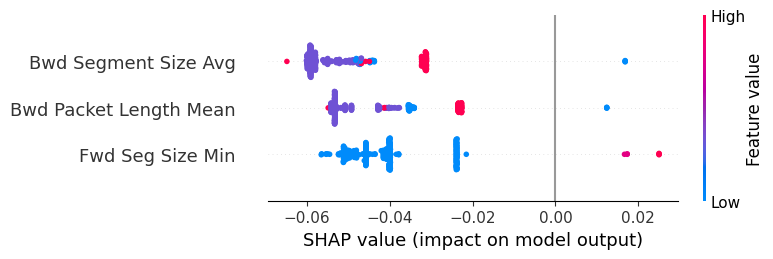

In [228]:
shap.summary_plot(rf_shap_failed[:,:,1], max_display=3)

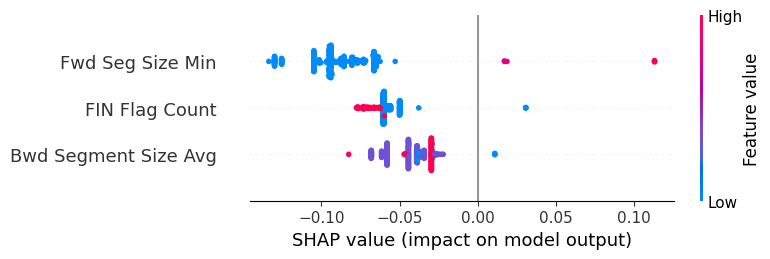

In [229]:
shap.summary_plot(et_shap_failed[:,:,1], max_display=3)

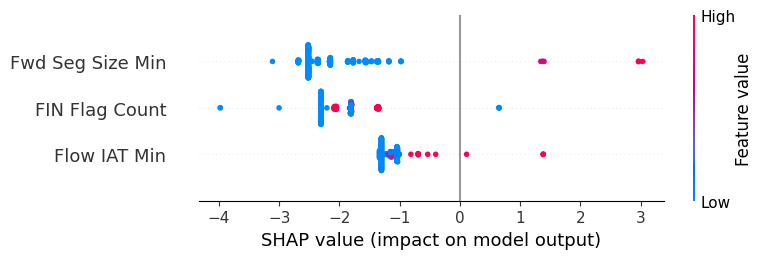

In [230]:
shap.summary_plot(xg_shap_failed, max_display=3)

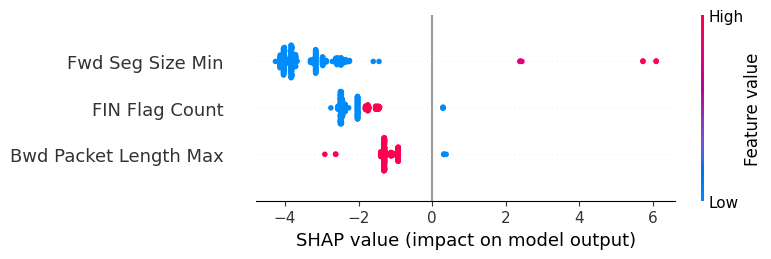

In [231]:
shap.summary_plot(lgbm_shap_failed, max_display=3)

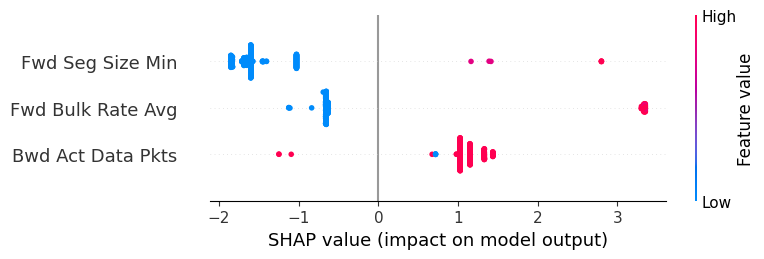

In [232]:
shap.summary_plot(cat_shap_failed, max_display=3)

In [211]:
def show_kde_plot(selected_feature):
    _, axes = plt.subplots(1, 3, figsize=(18, 3))

    sns.kdeplot(data=slowloris_train[[selected_feature]], x=selected_feature, fill=True, ax=axes[0])
    axes[0].set_title(f'{selected_feature} on Training Slowloris')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Density')

    sns.kdeplot(data=majority_success_slowloris[[selected_feature]], x=selected_feature, fill=True, ax=axes[1])
    axes[1].set_title(f'{selected_feature} on Test Slowloris (Success)')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Density')

    sns.kdeplot(data=majority_fail_slowloris[[selected_feature]], x=selected_feature, fill=True, ax=axes[2])
    axes[2].set_title(f'{selected_feature} on Test Slowloris (Failed)')
    axes[2].set_xlabel('Value')
    axes[2].set_ylabel('Density')

    plt.show()

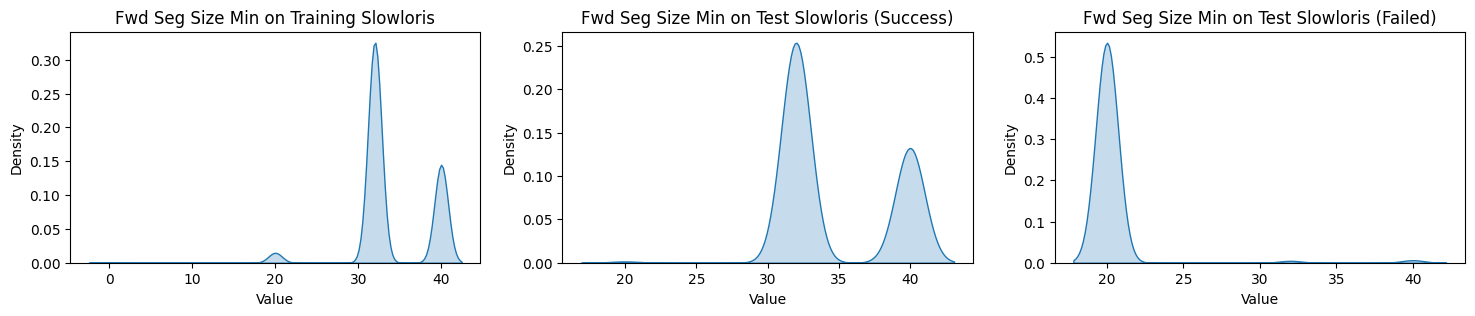

In [212]:
show_kde_plot('Fwd Seg Size Min')

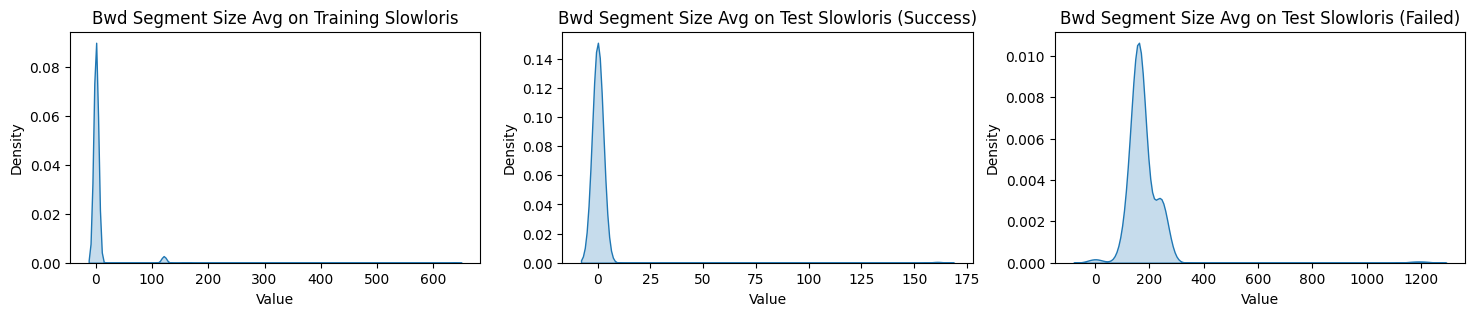

In [233]:
show_kde_plot('Bwd Segment Size Avg')

In [154]:
slowloris_train[selected_feature].describe()

count    4565.000000
mean        3.834064
std        22.971800
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       637.750000
Name: Bwd Segment Size Avg, dtype: float64

In [156]:
majority_success_slowloris[selected_feature].describe()

count    782.000000
mean       0.617647
std        9.959243
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      161.000000
Name: Bwd Segment Size Avg, dtype: float64

In [157]:
majority_fail_slowloris[selected_feature].describe()

count     356.000000
mean      177.257693
std        86.676658
min         0.000000
25%       161.000000
50%       161.000000
75%       161.000000
max      1213.000000
Name: Bwd Segment Size Avg, dtype: float64

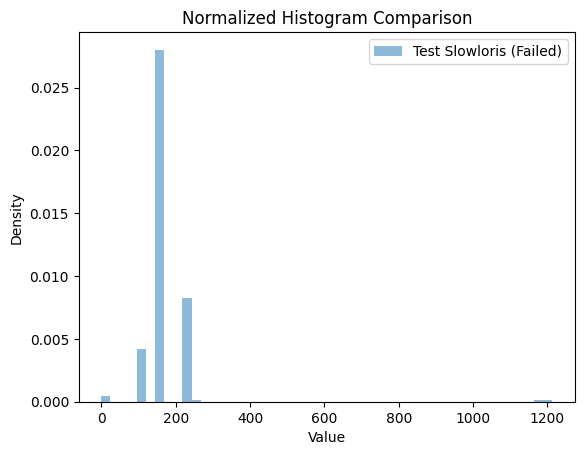

In [162]:
# plt.hist(slowloris_train[[selected_feature]], bins=50, density=True, alpha=0.5, label='Training Slowloris')
# plt.hist(majority_success_slowloris[[selected_feature]], bins=50, density=True, alpha=0.5, label='Test Slowloris (Success)')
plt.hist(majority_fail_slowloris[[selected_feature]], bins=50, density=True, alpha=0.5, label='Test Slowloris (Failed)')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Normalized Histogram Comparison')
plt.show()

In [44]:
y = flink_test['Label']

In [60]:
y_train = flink_train['Label']

In [61]:
slowloris_train_idx = y_train[y_train == 'Slowloris'].index
slowloris_train_idx

Index([39828, 39829, 39830, 39831, 39832, 39833, 39834, 39835, 39836, 39837,
       ...
       60206, 60207, 60208, 60209, 60210, 60211, 60212, 60213, 60214, 60215],
      dtype='int64', length=4565)

In [65]:
X_train = flink_train[fs].loc[slowloris_train_idx]

In [45]:
fail_idx = y[((y_pred == 0) & (y == 'Slowloris'))].index
fail_idx

Index([2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947,
       ...
       3356, 3358, 3359, 3368, 3482, 3483, 3956, 3957, 3958, 3959],
      dtype='int64', length=300)

In [46]:
slowloris_test_idx = y[y == 'Slowloris'].index
slowloris_test_idx

Index([ 324,  338,  339,  342,  343,  350,  351,  367,  368,  372,
       ...
       3948, 3949, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959],
      dtype='int64', length=1138)

In [47]:
slowloris_test_success_idx = slowloris_test_idx[~slowloris_test_idx.isin(fail_idx)]
slowloris_test_success_idx

Index([ 324,  338,  339,  342,  343,  350,  351,  367,  368,  372,
       ...
       3941, 3943, 3946, 3947, 3948, 3949, 3952, 3953, 3954, 3955],
      dtype='int64', length=838)

In [93]:
X_test = flink_test[fs].loc[slowloris_test_idx]

In [53]:
X_success = flink_test[fs].loc[slowloris_test_success_idx]

In [48]:
X_failed = flink_test[fs].loc[fail_idx]

In [ ]:
import shap

/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [121]:
xg = joblib.load(f"{DOS_MODEL_LOCATION}/xg_tuned.pkl")

In [51]:
explainer = shap.TreeExplainer(xg)

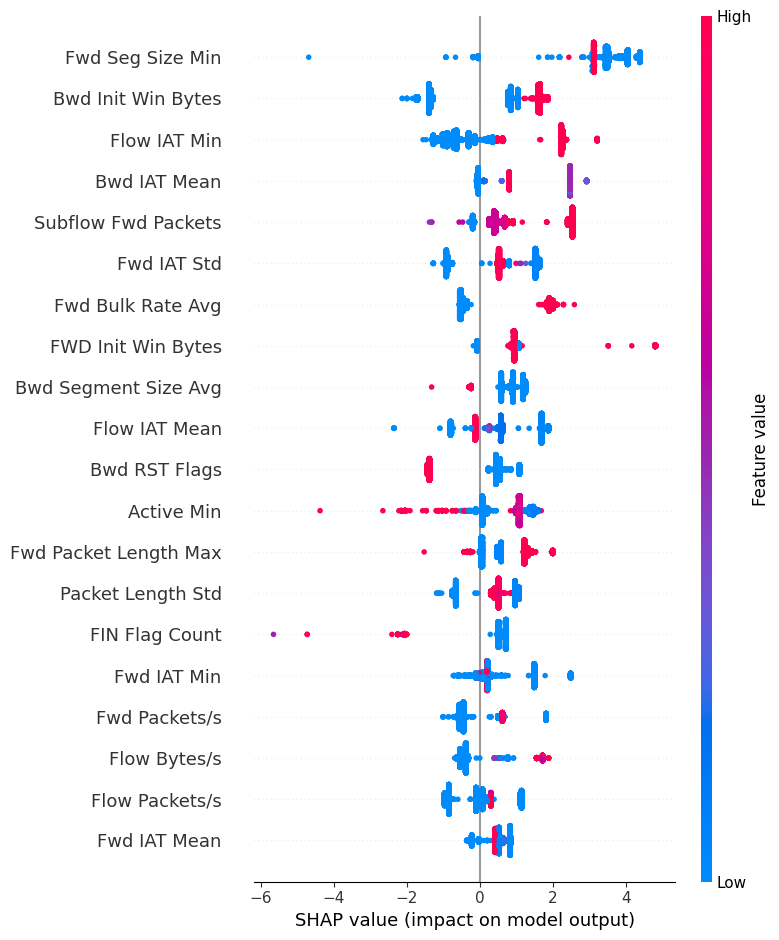

In [67]:
shap_values = explainer(X_train)
shap.summary_plot(shap_values)

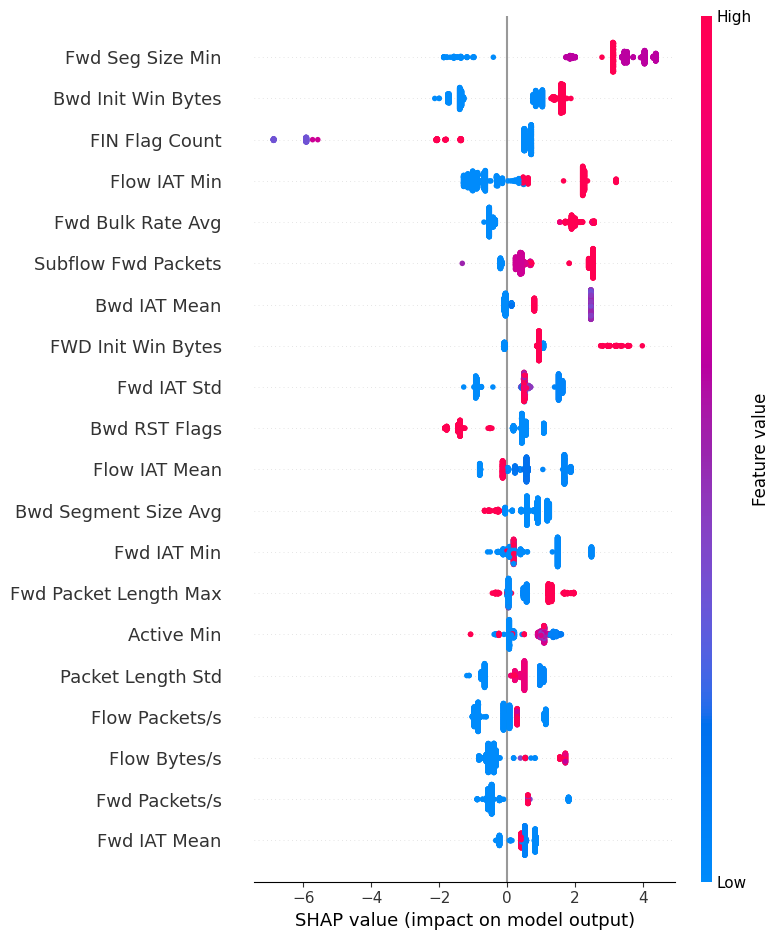

In [54]:
shap_values = explainer(X_success)
shap.summary_plot(shap_values)

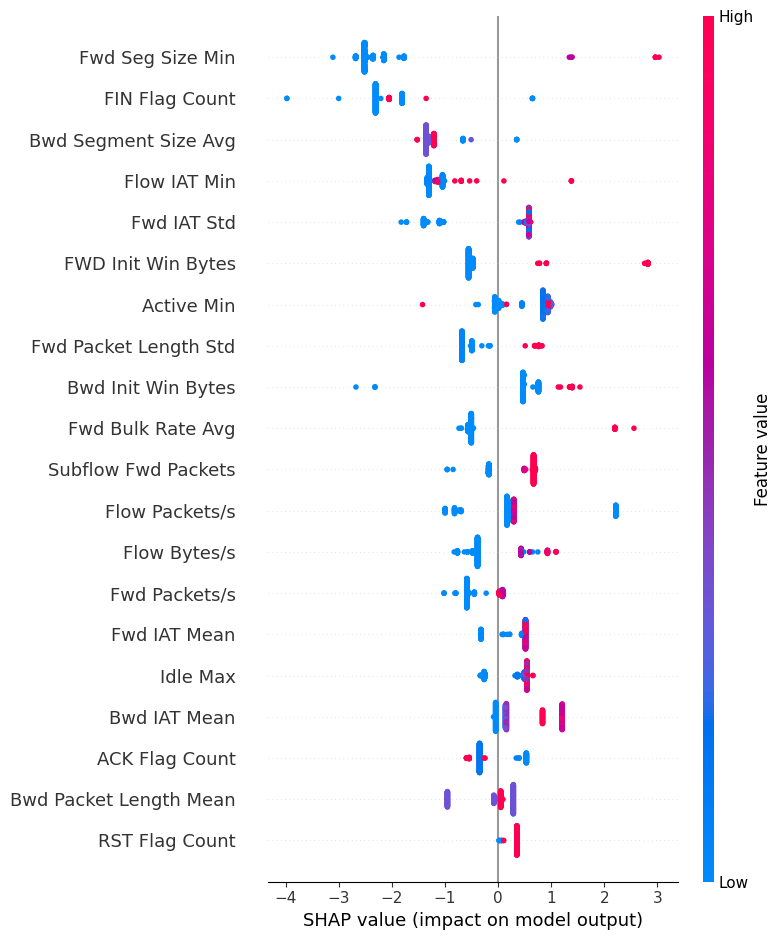

In [52]:
shap_values = explainer(X_failed)
shap.summary_plot(shap_values)

In [68]:
import shap

# Use TreeExplainer for tree-based models
explainer = shap.TreeExplainer(xg)

# Compute SHAP values
shap_values_train = explainer(X_train)
shap_values_test_success = explainer(X_success)
shap_values_test_failed = explainer(X_failed)
# shap_values_test = explainer(slowloris_test_reset[fs])

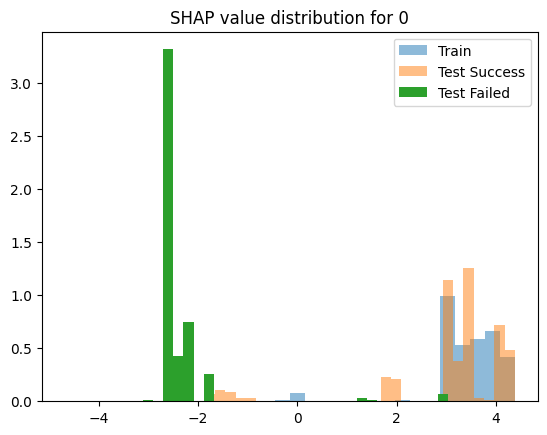

In [75]:
import matplotlib.pyplot as plt

# Choose a feature of interest
feature = 0

# SHAP values for that feature
train_vals = shap_values_train[:, feature].values
# test_vals = shap_values_test[:, feature].values
test_success_vals = shap_values_test_success[:, feature].values
test_failed_vals = shap_values_test_failed[:, feature].values

plt.hist(train_vals, bins=30, alpha=0.5, label='Train', density=True)
# plt.hist(test_vals, bins=30, alpha=0.5, label='Test', density=False)
plt.hist(test_success_vals, bins=30, alpha=0.5, label='Test Success', density=True)
plt.hist(test_failed_vals, bins=30, alpha=1, label='Test Failed', density=True)
plt.title(f'SHAP value distribution for {feature}')
plt.legend()
plt.show()

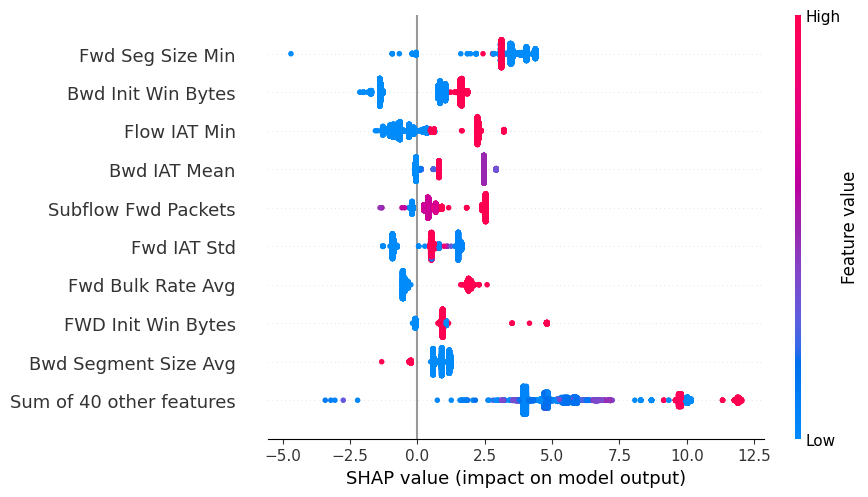

In [77]:
shap.plots.beeswarm(shap_values_train)

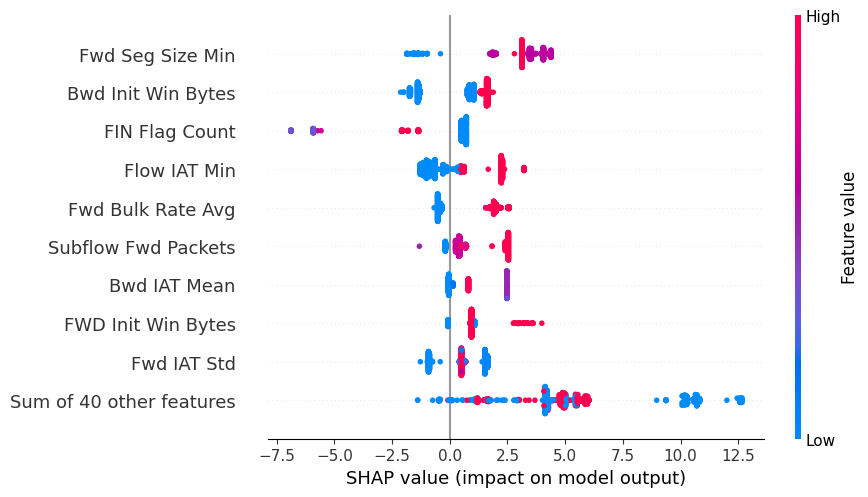

In [78]:
shap.plots.beeswarm(shap_values_test_success)

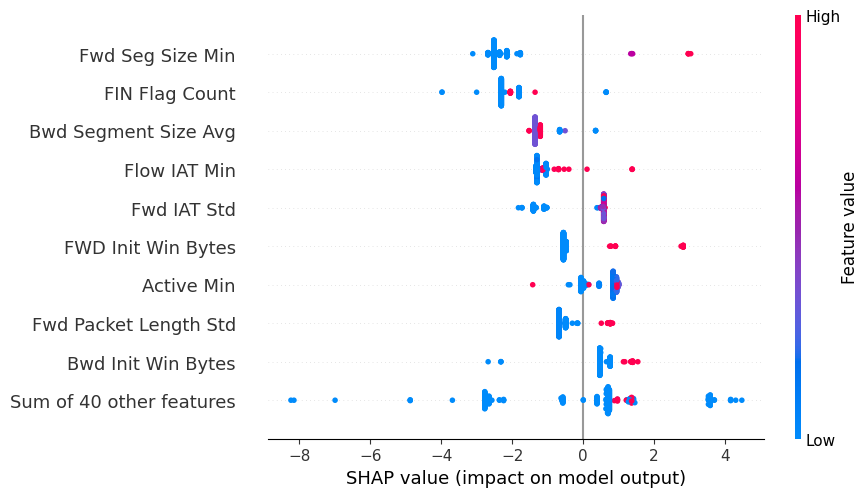

In [80]:
shap.plots.beeswarm(shap_values_test_failed)

In [81]:
X_train['Fwd Seg Size Min'].describe()

count    4565.000000
mean       34.013582
std         4.426515
min         0.000000
25%        32.000000
50%        32.000000
75%        40.000000
max        40.000000
Name: Fwd Seg Size Min, dtype: float64

In [82]:
X_success['Fwd Seg Size Min'].describe()

count    838.000000
mean      33.704057
std        5.259185
min       20.000000
25%       32.000000
50%       32.000000
75%       40.000000
max       40.000000
Name: Fwd Seg Size Min, dtype: float64

In [83]:
X_failed['Fwd Seg Size Min'].describe()

count    300.000000
mean      20.386667
std        2.577979
min       20.000000
25%       20.000000
50%       20.000000
75%       20.000000
max       40.000000
Name: Fwd Seg Size Min, dtype: float64

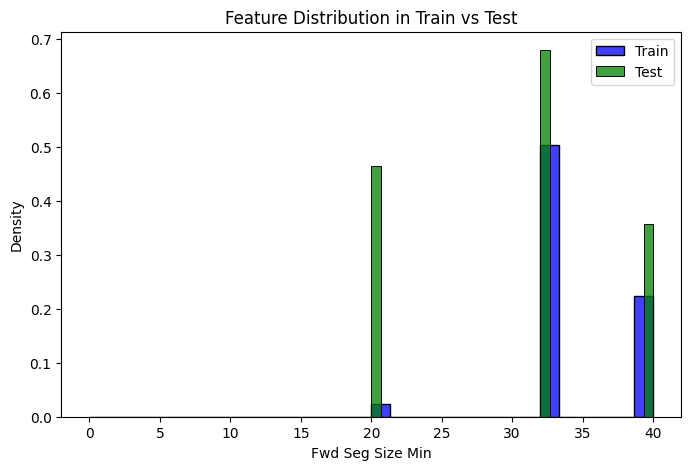

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(X_train['Fwd Seg Size Min'], color='blue', label='Train', kde=False, stat="density", bins=30)
sns.histplot(X_test['Fwd Seg Size Min'], color='green', label='Test', kde=False, stat="density", bins=30)
# sns.histplot(X_failed['Fwd Seg Size Min'], color='red', label='Test (Failed)', kde=True, stat="density", bins=30)
plt.title('Feature Distribution in Train vs Test')
plt.legend()
plt.show()

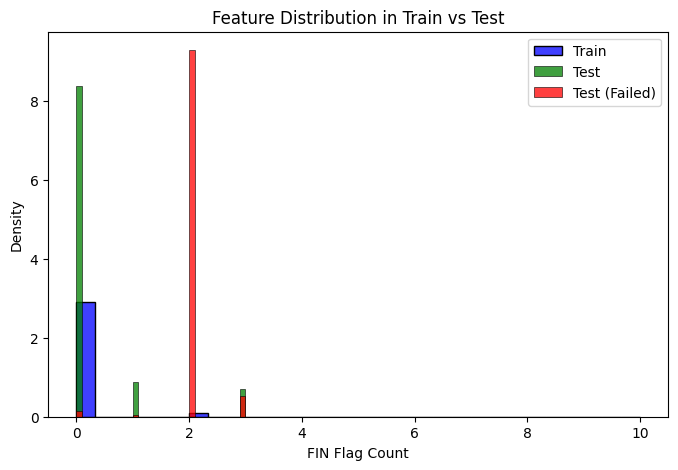

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(X_train['FIN Flag Count'], color='blue', label='Train', kde=False, stat="density", bins=30)
sns.histplot(X_success['FIN Flag Count'], color='green', label='Test', kde=False, stat="density", bins=30)
sns.histplot(X_failed['FIN Flag Count'], color='red', label='Test (Failed)', kbde=False, stat="density", bins=30)
plt.title('Feature Distribution in Train vs Test')
plt.legend()
plt.show()

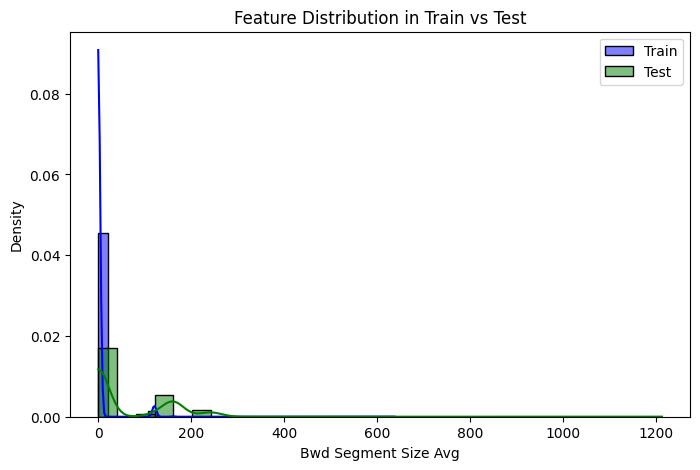

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(X_train['Bwd Segment Size Avg'], color='blue', label='Train', kde=True, stat="density", bins=30)
sns.histplot(X_test['Bwd Segment Size Avg'], color='green', label='Test', kde=True, stat="density", bins=30)
# sns.histplot(X_failed['Bwd Segment Size Avg'], color='red', label='Test (Failed)', kde=True, stat="density", bins=30)
plt.title('Feature Distribution in Train vs Test')
plt.legend()
plt.show()